### Image Classification using EfficientNet

1. Import Libraries

In [64]:
import os
import random
import cv2
import imutils

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense

2. Prepare directories for data

In [65]:
train_dir = '../../dataset_26'
test_dir = '../../dataset_26'

train_data_dir = 'content/Train-Data'
test_data_dir = 'content/Test-Data'

classes = os.listdir(train_dir) 

# Create main directories if they do not exist
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)


# Create subdirectories for each class if they do not exist
for cls in classes:
    os.makedirs(f'{train_data_dir}/{cls}', exist_ok=True)
    os.makedirs(f'{test_data_dir}/{cls}', exist_ok=True)

In [66]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [67]:
train_files_path = {cls: list(map(lambda x: os.path.join(train_dir, cls, x), os.listdir(os.path.join(train_dir, cls)))) for cls in classes}

3. Visualise the data

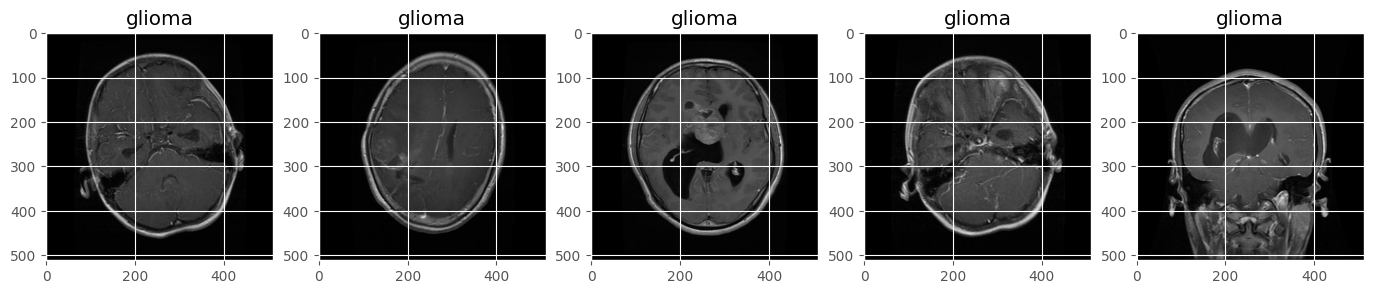

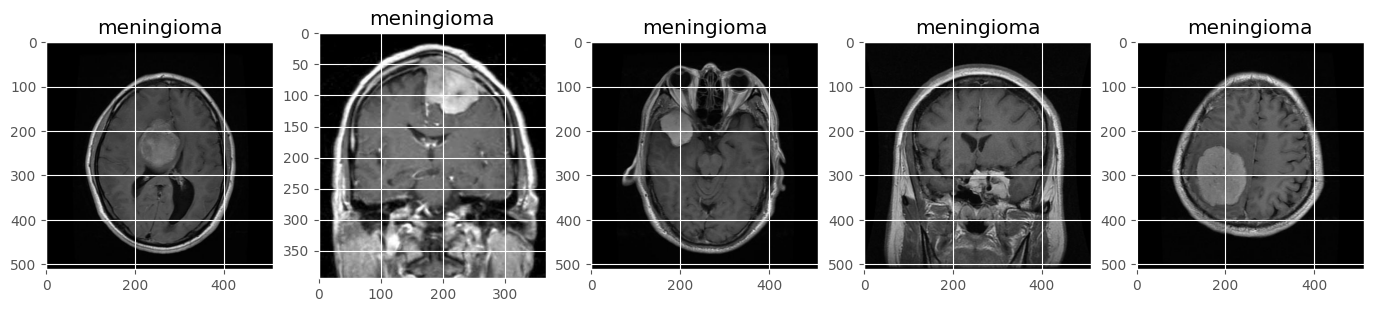

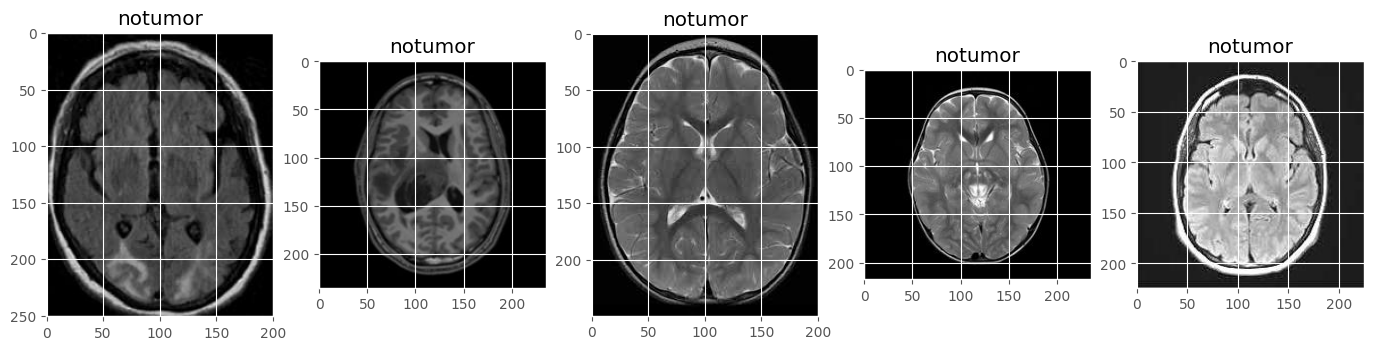

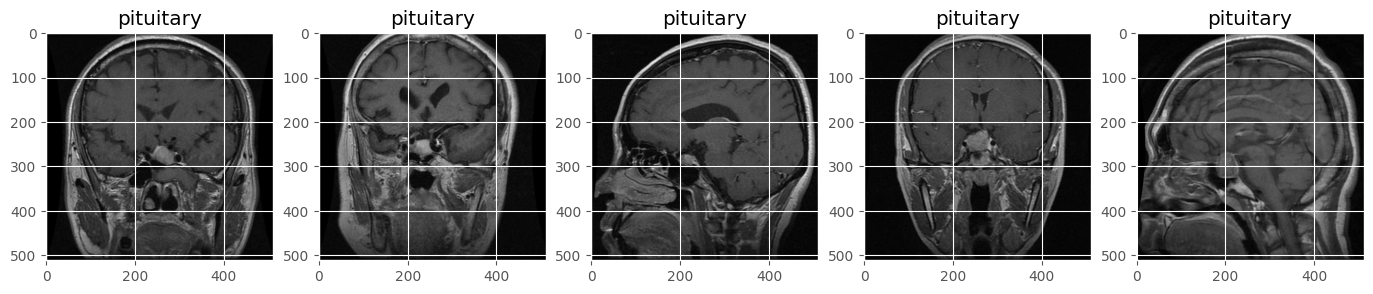

In [68]:
for cls in classes:
  plt.figure(figsize=(17, 17))
  random.shuffle(train_files_path[cls])
  files = train_files_path[cls][:5]

  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(load_img(files[i]))
    plt.title(cls)
  plt.show()

4. Data Augmentation

In [69]:
def crop_image(image, plot=False):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

In [70]:
train_class_paths = [os.path.join(train_dir, cls) for cls in classes]
test_class_paths = [os.path.join(test_dir, cls) for cls in classes]

In [71]:
def crop_img_saver(class_read_paths, save_dir):
  save_root = 'content'
  for cls in class_read_paths:
    for i, p in tqdm(enumerate(os.listdir(cls))):
      path = os.path.join(cls, p)
      img = crop_image(cv2.imread(path), plot=False)

      if img is not None:
        img = cv2.resize(img, (224, 224))
        save_class = cls.split('\\')[-1]
        save_path = os.path.join(save_root, save_dir, save_class, f'{str(i)}.jpg')
        cv2.imwrite(save_path, img)

In [72]:
crop_img_saver(train_class_paths, save_dir='Train-Data')
crop_img_saver(test_class_paths, save_dir='Test-Data')

120it [00:01, 95.29it/s]
120it [00:00, 142.16it/s]
120it [00:00, 141.92it/s]
120it [00:00, 125.04it/s]
120it [00:00, 158.97it/s]
120it [00:00, 171.47it/s]
120it [00:00, 172.70it/s]
120it [00:00, 143.96it/s]


In [73]:
train_data_generator = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_data = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

test_data_generator = ImageDataGenerator()

test_data = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    class_mode='categorical'
)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Found 480 images belonging to 4 classes.


In [74]:
print(train_data.class_indices, test_data.class_indices, sep='\n')

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


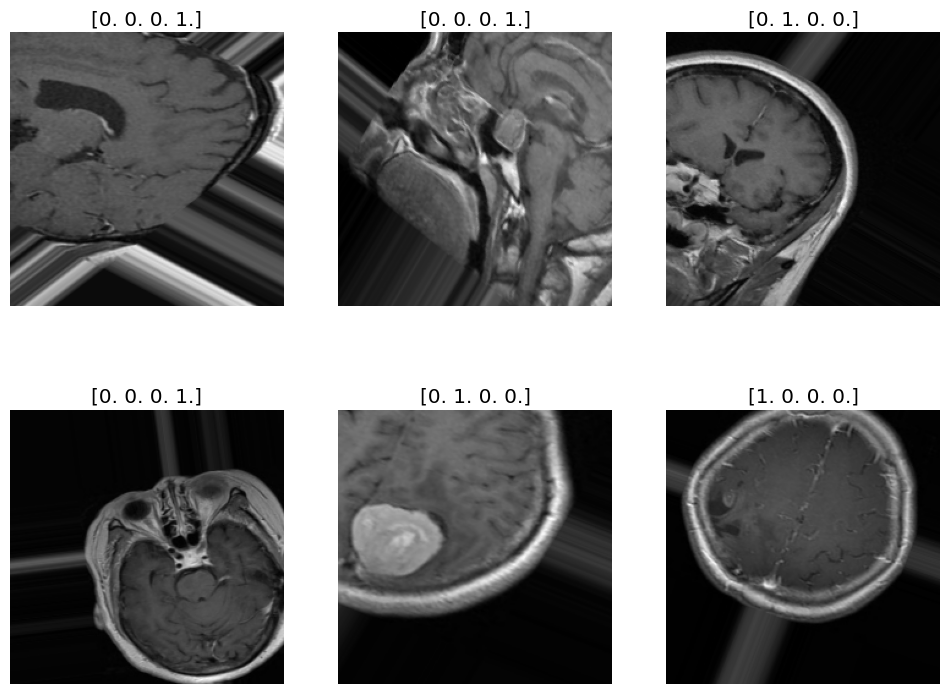

In [75]:
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.axis('off'), plt.grid(False)
  plt.imshow(array_to_img(sample_x[i]))
  plt.title(sample_y[i])

5. Build the model

In [76]:
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, outputs=model)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 224, 224,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 224, 224,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 224, 224,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

6. Train the model

In [77]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='auto',
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model_ckpt.model.keras', 
    monitor='val_accuracy',
    save_best_only=True,
    mode='auto',
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=2, 
    min_lr=1e-6,
    verbose=1
)

In [78]:
history = model.fit(
    train_data, 
    epochs=20, 
    validation_data=validation_data, 
    callbacks=[checkpoint, early_stopping, reduce_lr], 
    verbose=1
)

Epoch 1/20


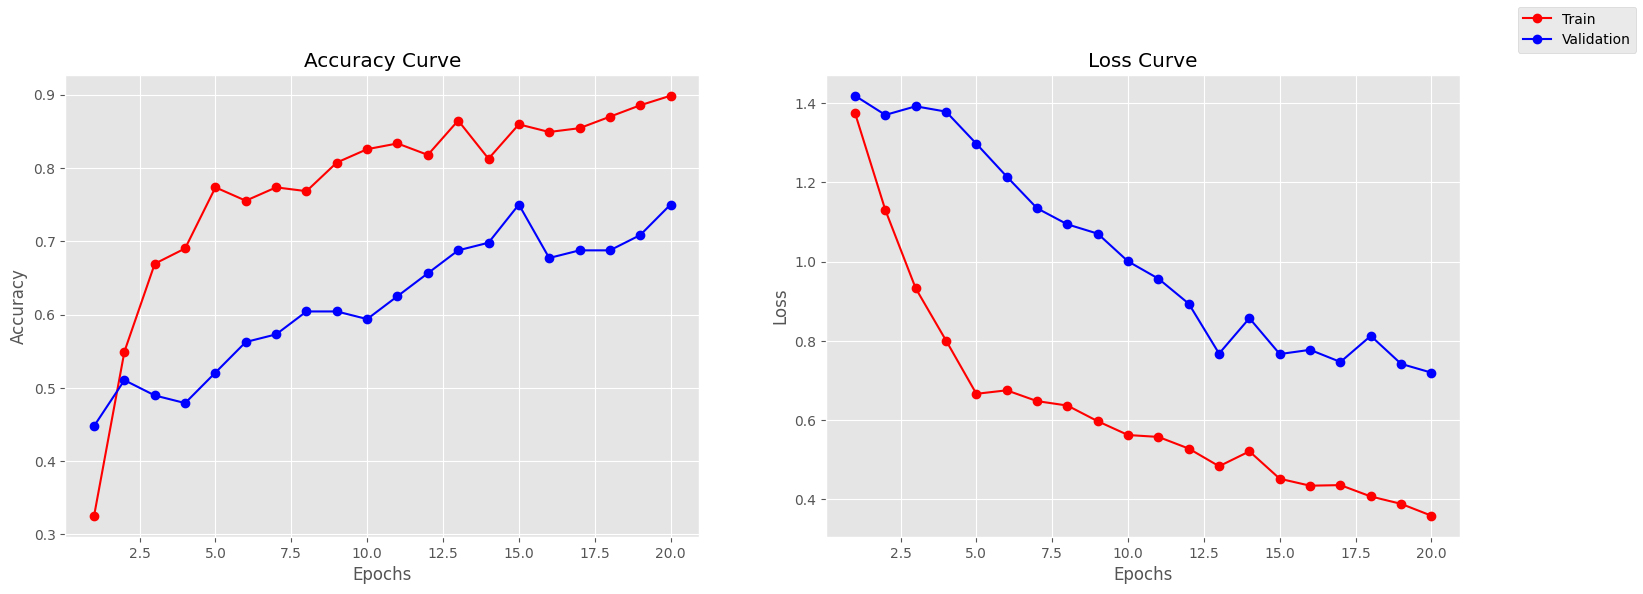

In [ ]:
plt.style.use('ggplot')
figure = plt.figure(figsize=(18, 6))
epochs = range(1, 21)

plt.subplot(121)
plt.plot(epochs, history.history['accuracy'], 'ro-')
plt.plot(epochs, history.history['val_accuracy'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Accuracy'), plt.title('Accuracy Curve')

plt.subplot(122)
plt.plot(epochs, history.history['loss'], 'ro-')
plt.plot(epochs, history.history['val_loss'], 'bo-')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Loss Curve')

figure.legend(['Train', 'Validation'])

7. Evaluation

In [ ]:
model.evaluate(test_data)

C:\Users\Mirza Anaqi\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7493 - loss: 0.7229


[0.7524639368057251, 0.7458333373069763]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Model prediction probabilities: [[0.17635672 0.3804977  0.18635747 0.25678816]]
Output Class Label: 1
Predicted Class: meningioma


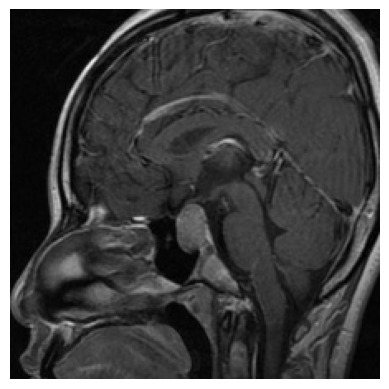

In [ ]:
label_map = {v: k for k, v in test_data.class_indices.items()}

test_image_path = 'content/Test-Data/pituitary/100.jpg'
test_image = cv2.imread(test_image_path)
plt.grid(False), plt.axis('off')
plt.imshow(test_image)
test_image = cv2.resize(test_image, (224, 224))  # Ensure image is resized before prediction
test_image = np.expand_dims(test_image, axis=0)

pred = model.predict(test_image)
print(f'Model prediction probabilities: {pred}')
pred = np.argmax(pred)
print(f'Output Class Label: {pred}')
pred = label_map[pred]
print(f'Predicted Class: {pred}')